In [20]:
initial_value = 1.00

✅ Imports successful!
✅ Controller implementations loaded!
✅ Benchmark functions created!
✅ Benchmark framework ready!
✅ Controller factories defined!

🚀 Starting benchmark comparison...
This may take a minute...


Evaluating: Base ESC
  Testing on: unimodal_easy... ✓ (Avg Error: 0.0003, Avg Conv: 20)
  Testing on: unimodal_noisy... ✓ (Avg Error: 0.0014, Avg Conv: 20)
  Testing on: bimodal... ✓ (Avg Error: 0.7000, Avg Conv: 500)
  Testing on: multimodal... ✓ (Avg Error: 0.0003, Avg Conv: 20)
  Testing on: moving_sine... ✓ (Avg Error: 0.1988, Avg Conv: 500)
  Testing on: rugged... ✓ (Avg Error: 0.3005, Avg Conv: 500)

Evaluating: Smart Adaptive ESC
  Testing on: unimodal_easy... ✓ (Avg Error: 0.0002, Avg Conv: 20)
  Testing on: unimodal_noisy... ✓ (Avg Error: 0.0013, Avg Conv: 20)
  Testing on: bimodal... ✓ (Avg Error: 0.6999, Avg Conv: 500)
  Testing on: multimodal... ✓ (Avg Error: 0.0003, Avg Conv: 20)
  Testing on: moving_sine... ✓ (Avg Error: 0.1988, Avg Conv: 500)
  Testing on: rug

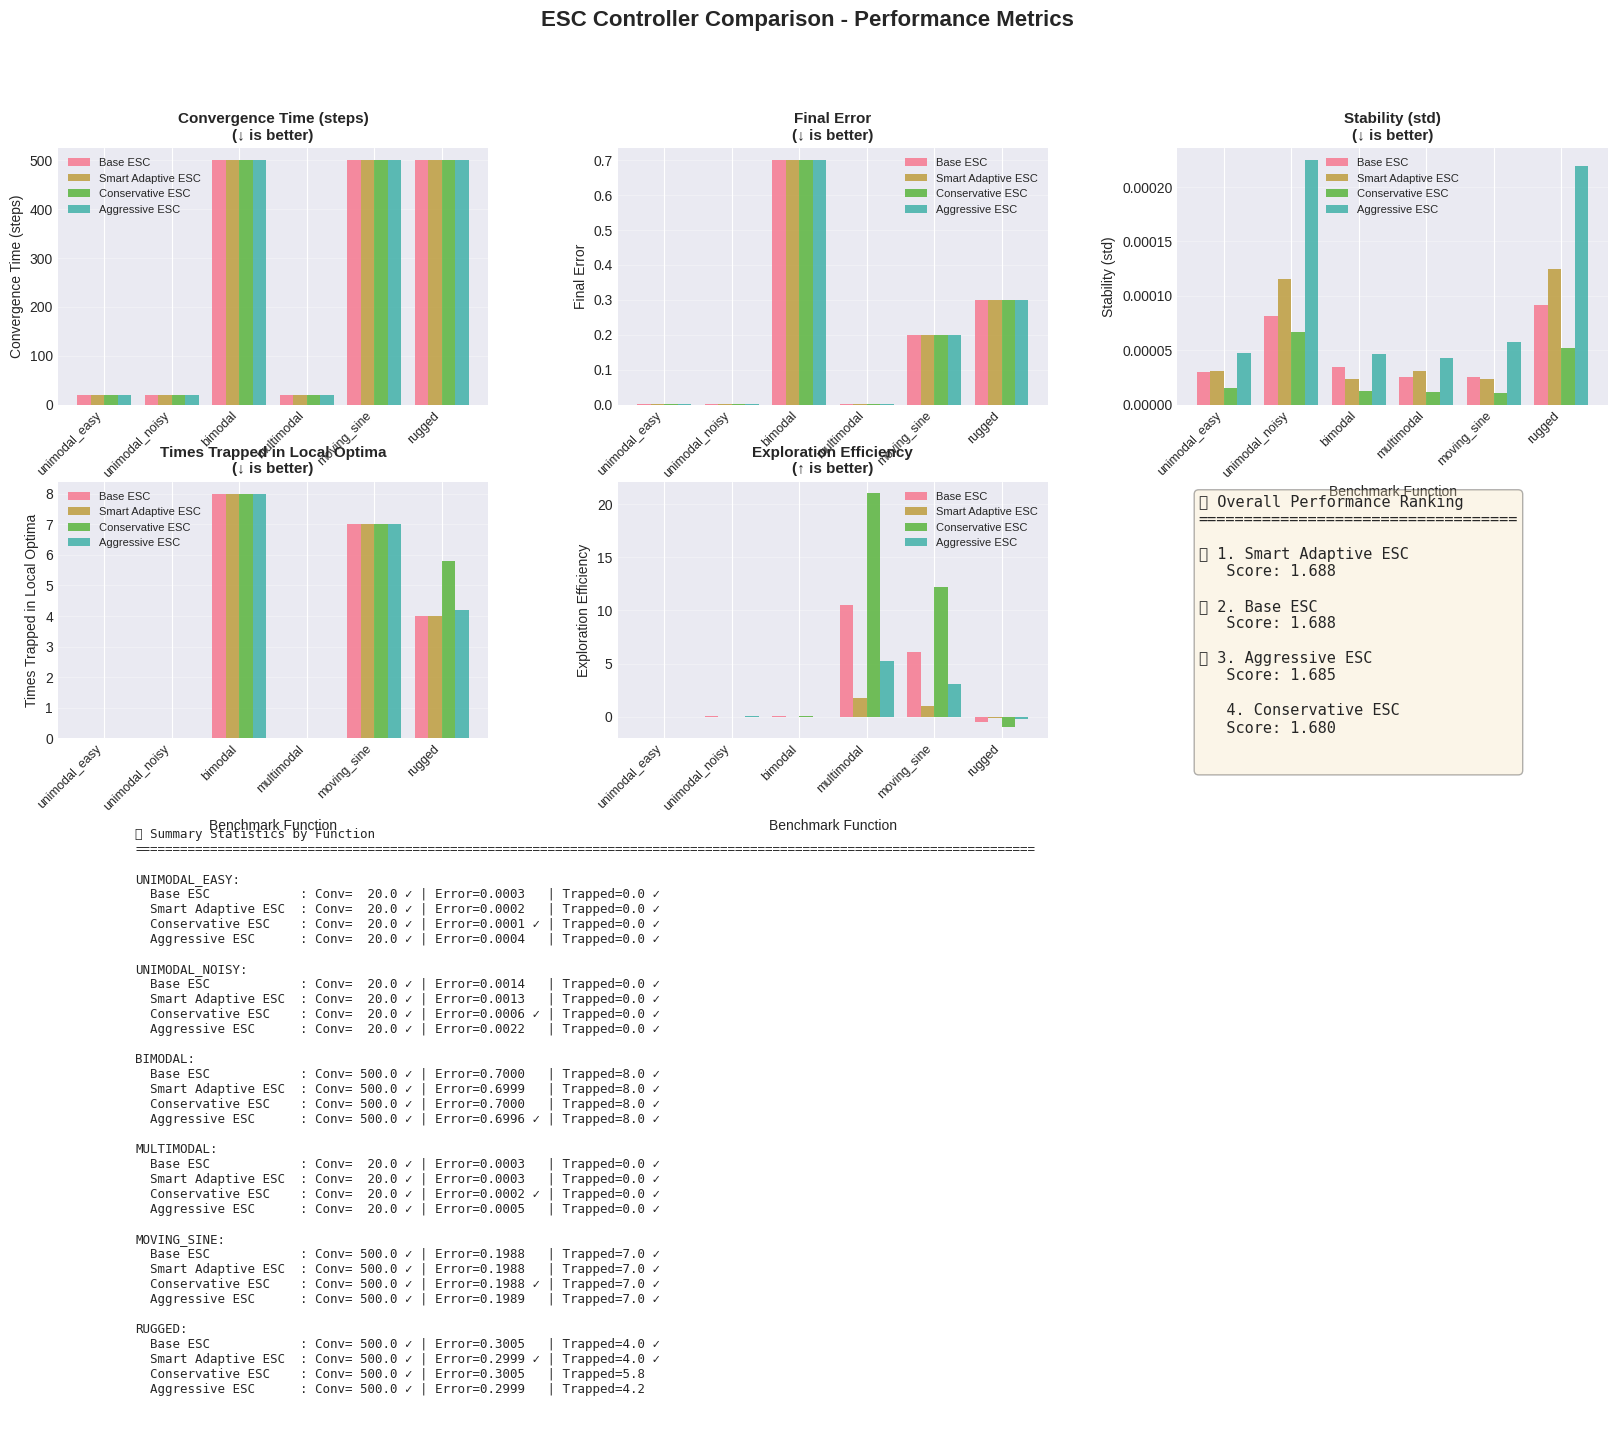


✅ Performance metrics plotted!


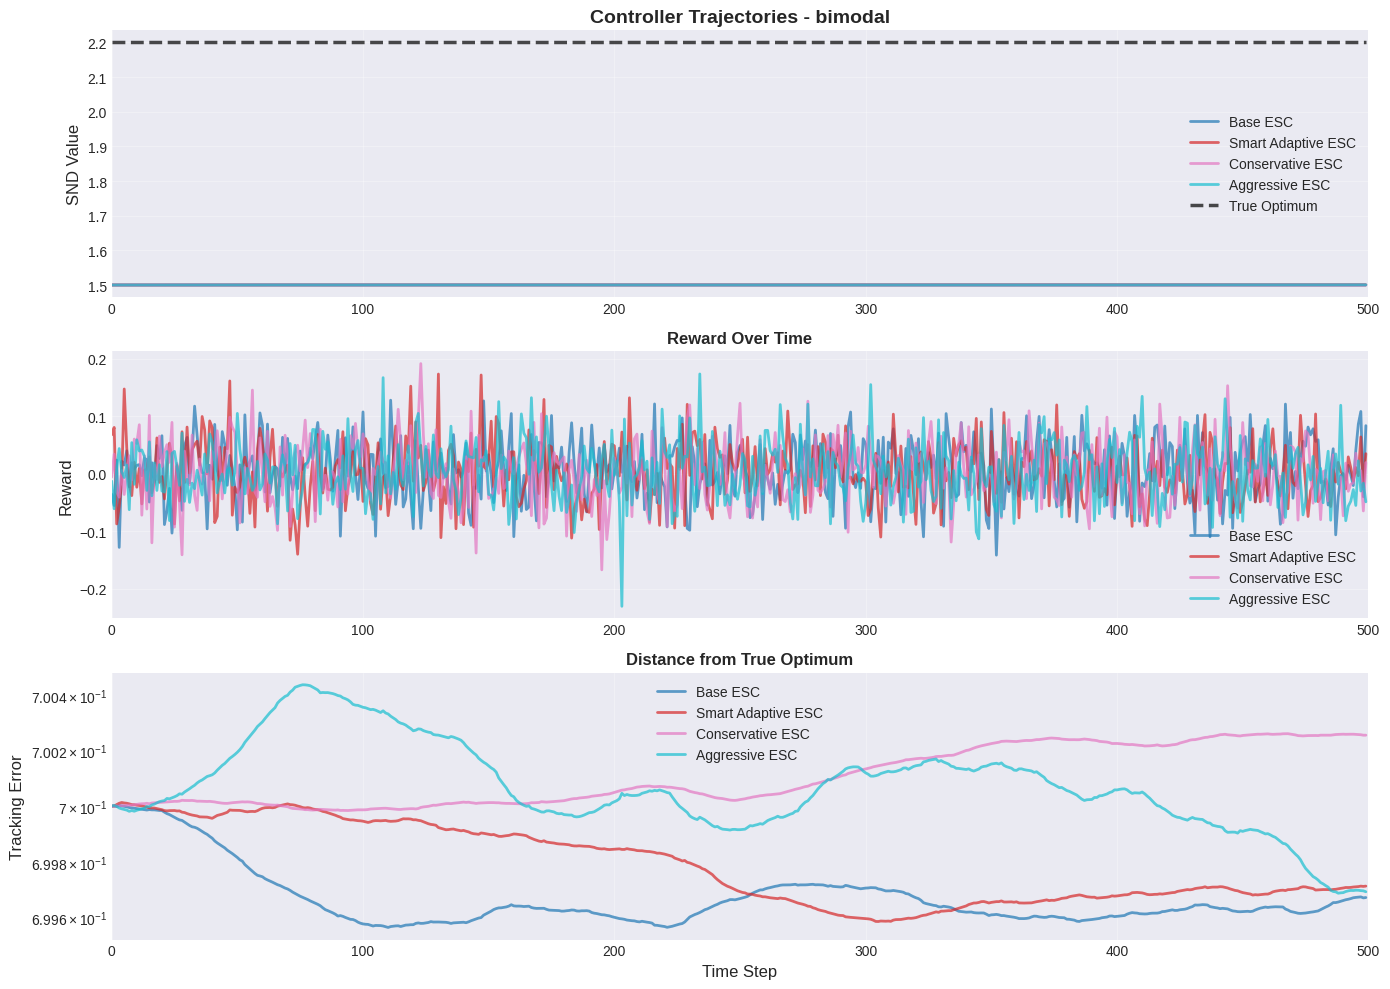

✅ Trajectories plotted for bimodal


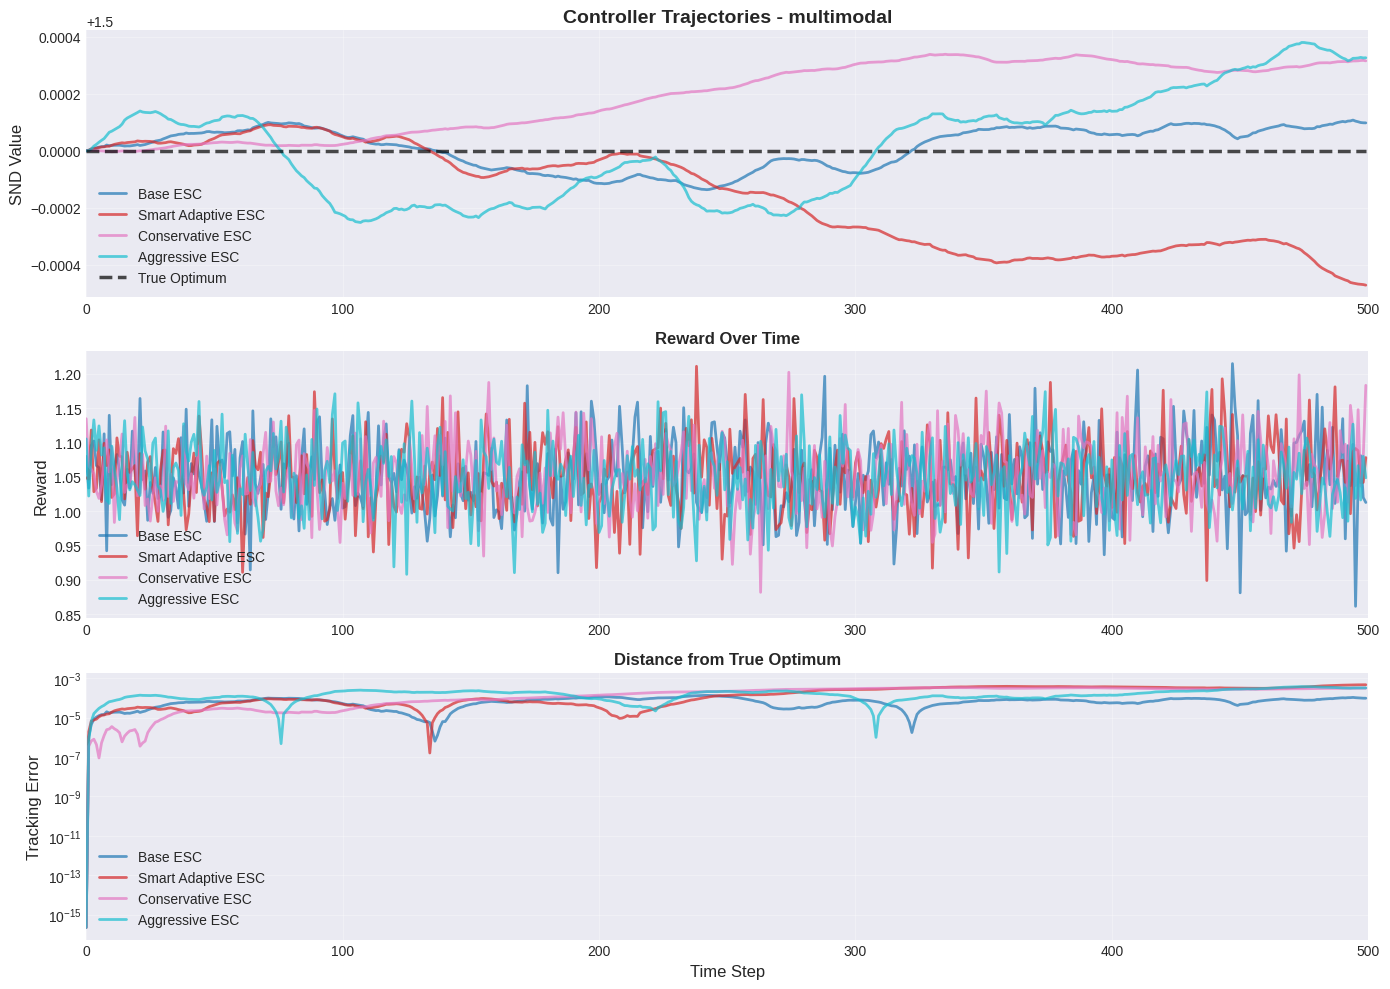

✅ Trajectories plotted for multimodal


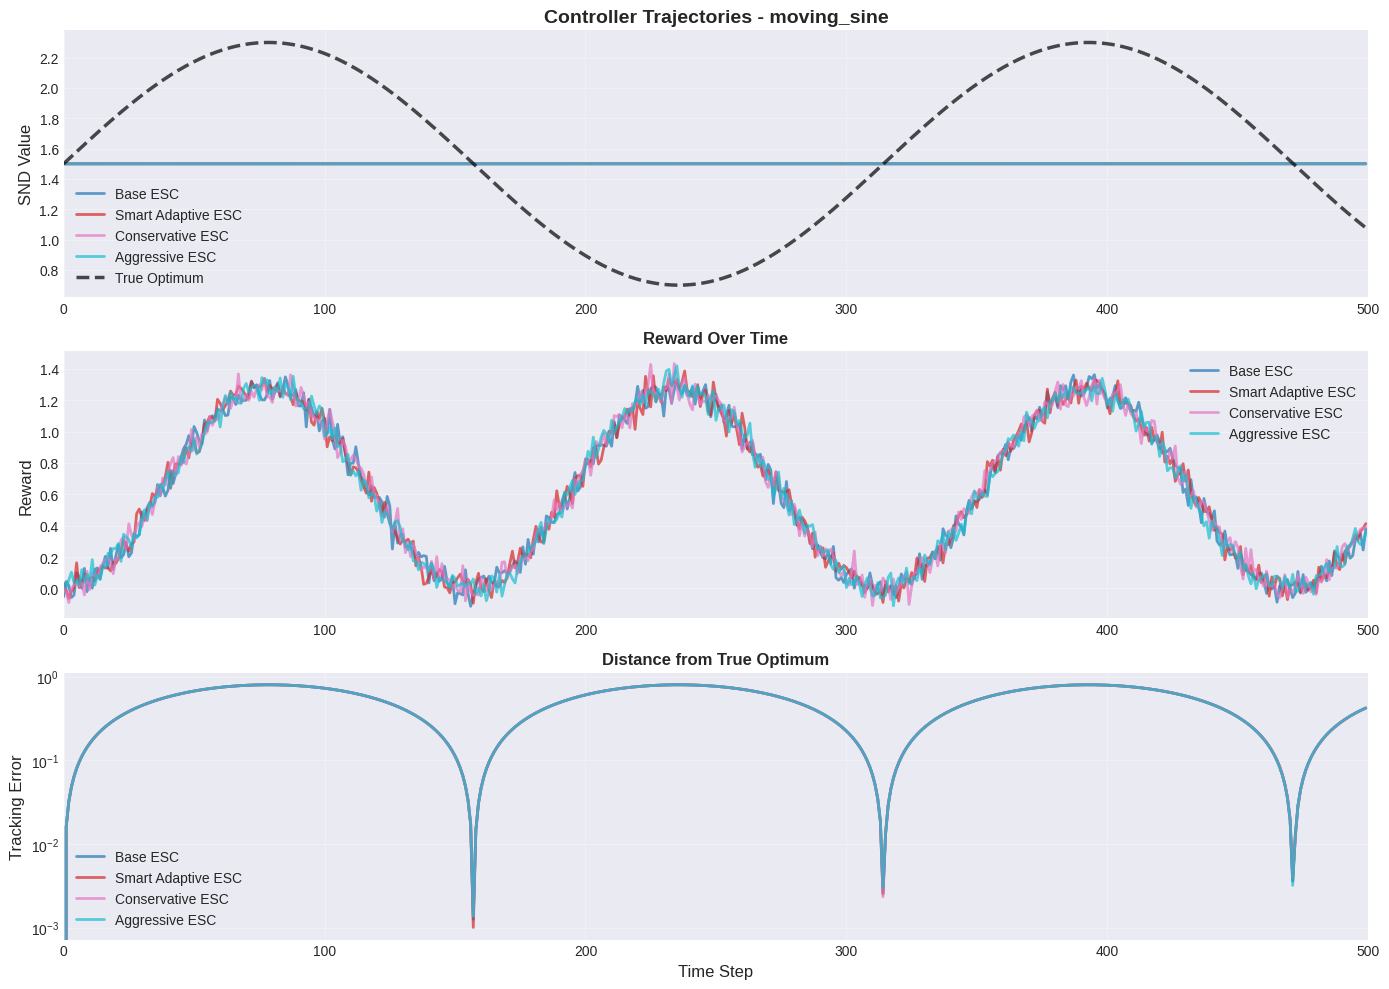

✅ Trajectories plotted for moving_sine

Statistical Significance Testing - final_error_mean


UNIMODAL_EASY:
----------------------------------------------------------------------
  Base ESC             vs Smart Adaptive ESC  : p=0.4915 ns  | Cohen's d=+0.331 | Δ=+0.0001
  Base ESC             vs Conservative ESC    : p=0.0445 *   | Cohen's d=+1.018 | Δ=+0.0001
  Base ESC             vs Aggressive ESC      : p=0.4868 ns  | Cohen's d=-0.335 | Δ=-0.0001
  Smart Adaptive ESC   vs Conservative ESC    : p=0.0796 ns  | Cohen's d=+0.876 | Δ=+0.0001
  Smart Adaptive ESC   vs Aggressive ESC      : p=0.2289 ns  | Cohen's d=-0.587 | Δ=-0.0001
  Conservative ESC     vs Aggressive ESC      : p=0.0407 *   | Cohen's d=-1.039 | Δ=-0.0002

UNIMODAL_NOISY:
----------------------------------------------------------------------
  Base ESC             vs Smart Adaptive ESC  : p=0.8817 ns  | Cohen's d=+0.071 | Δ=+0.0001
  Base ESC             vs Conservative ESC    : p=0.0542 ns  | Cohen's d=+0.971 | Δ=+0.0

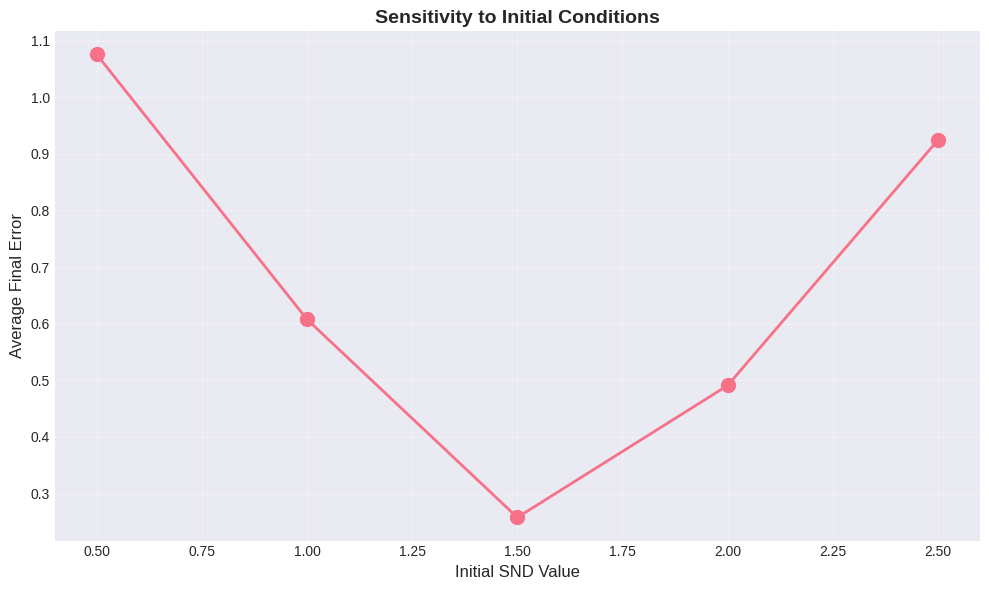


✅ Results exported to: esc_benchmark_results.json

RECOMMENDATIONS BASED ON BENCHMARK RESULTS


UNIMODAL_EASY:
  🏆 Fastest Convergence: Base ESC
  🎯 Lowest Final Error:  Conservative ESC
  📊 Most Stable:         Conservative ESC

UNIMODAL_NOISY:
  🏆 Fastest Convergence: Base ESC
  🎯 Lowest Final Error:  Conservative ESC
  📊 Most Stable:         Conservative ESC

BIMODAL:
  🏆 Fastest Convergence: Base ESC
  🎯 Lowest Final Error:  Aggressive ESC
  📊 Most Stable:         Conservative ESC

MULTIMODAL:
  🏆 Fastest Convergence: Base ESC
  🎯 Lowest Final Error:  Conservative ESC
  📊 Most Stable:         Conservative ESC

MOVING_SINE:
  🏆 Fastest Convergence: Base ESC
  🎯 Lowest Final Error:  Conservative ESC
  📊 Most Stable:         Conservative ESC

RUGGED:
  🏆 Fastest Convergence: Base ESC
  🎯 Lowest Final Error:  Smart Adaptive ESC
  📊 Most Stable:         Conservative ESC

🏆 OVERALL WINNER: Conservative ESC
   (Won 10 out of 18 categories)

💡 USAGE RECOMMENDATIONS:
----------------------

In [21]:
# %% [markdown]
# # Extremum Seeking Control (ESC) Benchmark Suite
# 
# This notebook provides a comprehensive framework for evaluating and comparing ESC controllers
# on synthetic benchmark functions that mimic real training dynamics.
#
# **Key Features:**
# - Multiple benchmark functions (unimodal, multimodal, moving targets, etc.)
# - Statistical comparison across controllers
# - Visualization of trajectories and performance metrics
# - Fast evaluation without running full training experiments

# %% [markdown]
## 1. Setup and Imports

# %%
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from typing import Callable, Dict, List, Optional, Tuple
from dataclasses import dataclass
from collections import deque
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
np.random.seed(42)

print("✅ Imports successful!")

# %% [markdown]
## 2. ESC Controller Implementations
##
## We'll implement simplified versions of the controllers for benchmarking.
## You can replace these with your actual controller implementations.

# %%
class HighPassFilter:
    """First-order high-pass filter to remove DC offset from signals."""
    
    def __init__(self, sampling_period: float, cutoff_frequency: float):
        self.dt = sampling_period
        self.wc = cutoff_frequency
        self.alpha = self.wc / (self.wc + 1.0 / self.dt)
        self.prev_input = 0.0
        self.prev_output = 0.0
    
    def apply(self, input_signal: float) -> float:
        output = self.alpha * (self.prev_output + input_signal - self.prev_input)
        self.prev_input = input_signal
        self.prev_output = output
        return output
    
    def reset(self):
        self.prev_input = 0.0
        self.prev_output = 0.0


class LowPassFilter:
    """First-order low-pass filter to smooth signals."""
    
    def __init__(self, sampling_period: float, cutoff_frequency: float):
        self.dt = sampling_period
        self.wc = cutoff_frequency
        self.alpha = (self.dt * self.wc) / (1.0 + self.dt * self.wc)
        self.prev_output = 0.0
    
    def apply(self, input_signal: float) -> float:
        output = self.alpha * input_signal + (1.0 - self.alpha) * self.prev_output
        self.prev_output = output
        return output
    
    def reset(self):
        self.prev_output = 0.0


class BaseESCController:
    """Base ESC controller (Original version)."""
    
    def __init__(
        self,
        sampling_period: float = 1.0,
        dither_frequency: float = 0.5,
        dither_magnitude: float = 0.1,
        integrator_gain: float = -0.01,
        initial_value: float = 1.5,
        high_pass_cutoff: float = 0.1,
        low_pass_cutoff: float = 0.05,
        use_adaptive_gain: bool = True,
        min_output: float = 0.0
    ):
        self.dt = sampling_period
        self.omega = dither_frequency
        self.a = dither_magnitude
        self.k = integrator_gain
        self.theta_0 = initial_value
        self.use_adaptive = use_adaptive_gain
        self.min_output = min_output
        
        self.hpf = HighPassFilter(sampling_period, high_pass_cutoff)
        self.lpf = LowPassFilter(sampling_period, low_pass_cutoff)
        
        self.phase = 0.0
        self.integral = 0.0
        self.m2 = 0.0
        self.beta = 0.8
        self.epsilon = 1e-8
        self.gradient_threshold = 0.2
        self.high_gain = -0.025
    
    def update(self, cost: float) -> Tuple[float, float, float, float, float, float]:
        # High-pass filter
        hpf_output = self.hpf.apply(cost)
        
        # Demodulate
        demodulated = hpf_output * np.sin(self.phase)
        
        # Low-pass filter
        lpf_output = self.lpf.apply(demodulated)
        
        # Gradient magnitude
        self.m2 = self.beta * self.m2 + (1.0 - self.beta) * (lpf_output ** 2)
        gradient_magnitude = np.sqrt(self.m2)
        
        # Adaptive gain
        if self.use_adaptive:
            gain = self.high_gain if gradient_magnitude > self.gradient_threshold else self.k
        else:
            gain = self.k
        
        # Integrate
        self.integral += gain * lpf_output * self.dt
        
        # Compute setpoint
        setpoint_raw = self.theta_0 + self.integral
        setpoint = max(setpoint_raw, self.min_output)
        
        # Anti-windup
        if setpoint_raw < self.min_output:
            self.integral = self.min_output - self.theta_0
        
        # Add perturbation
        perturbation = self.a * np.sin(self.phase)
        output = setpoint + perturbation
        
        # Update phase
        self.phase += self.omega * self.dt
        if self.phase > 2 * np.pi:
            self.phase -= 2 * np.pi
        
        return output, hpf_output, lpf_output, gradient_magnitude, lpf_output, setpoint


class SmartESCController(BaseESCController):
    """Smart Adaptive ESC with state machine."""
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Adaptive parameters
        self.dither_min = self.a * 0.1
        self.dither_max = self.a * 2.0
        self.dither_current = self.a
        
        self.gain_min = self.k * 0.1
        self.gain_max = self.k * 10.0
        self.gain_current = self.k
        
        # State tracking
        self.state = 'exploration'  # exploration, seeking, converged, tracking
        self.step_count = 0
        self.stable_steps = 0
        self.exploration_steps = 500
        self.convergence_patience = 5
        
        self.gradient_history = deque(maxlen=10)
        self.setpoint_history = deque(maxlen=10)
        self.prev_setpoint = initial_value
    
    def _update_state(self, gradient_magnitude: float):
        """Update convergence state."""
        self.step_count += 1
        self.gradient_history.append(gradient_magnitude)
        self.setpoint_history.append(self.prev_setpoint)
        
        if self.state == 'exploration':
            if self.step_count >= self.exploration_steps:
                self.state = 'seeking'
        
        elif self.state == 'seeking':
            if len(self.gradient_history) >= self.convergence_patience:
                avg_grad = np.mean(list(self.gradient_history)[-self.convergence_patience:])
                setpoint_var = np.var(list(self.setpoint_history)[-self.convergence_patience:])
                
                if avg_grad < 0.05 and setpoint_var < 0.01:
                    self.stable_steps += 1
                    if self.stable_steps >= self.convergence_patience:
                        self.state = 'converged'
                else:
                    self.stable_steps = 0
        
        elif self.state == 'converged':
            if len(self.gradient_history) >= 10:
                avg_grad = np.mean(list(self.gradient_history))
                if avg_grad < 0.01:
                    self.state = 'tracking'
    
    def _compute_adaptive_dither(self, gradient_magnitude: float) -> float:
        """Compute adaptive dither magnitude."""
        state_multipliers = {
            'exploration': 1.5,
            'seeking': 1.0,
            'converged': 0.3,
            'tracking': 0.1,
        }
        
        base_dither = self.dither_current * state_multipliers[self.state]
        
        if gradient_magnitude > 0.2:
            gradient_factor = 0.7
        elif gradient_magnitude < 0.05:
            gradient_factor = 1.2
        else:
            gradient_factor = 1.0
        
        new_dither = base_dither * gradient_factor
        new_dither = np.clip(new_dither, self.dither_min, self.dither_max)
        
        alpha = 0.1
        self.dither_current = alpha * new_dither + (1 - alpha) * self.dither_current
        
        return self.dither_current
    
    def _compute_adaptive_gain(self, gradient_magnitude: float) -> float:
        """Compute adaptive integrator gain."""
        state_multipliers = {
            'exploration': 2.0,
            'seeking': 1.0,
            'converged': 0.3,
            'tracking': 0.1,
        }
        
        base_gain = self.gain_current * state_multipliers[self.state]
        
        if gradient_magnitude > 0.5:
            gradient_factor = 2.0
        elif gradient_magnitude > 0.2:
            gradient_factor = 1.5
        elif gradient_magnitude < 0.05:
            gradient_factor = 0.5
        else:
            gradient_factor = 1.0
        
        new_gain = base_gain * gradient_factor
        new_gain = np.clip(new_gain, self.gain_max, self.gain_min)
        
        alpha = 0.2
        self.gain_current = alpha * new_gain + (1 - alpha) * self.gain_current
        
        return self.gain_current
    
    def update(self, cost: float) -> Tuple[float, float, float, float, float, float]:
        # Standard ESC processing
        hpf_output = self.hpf.apply(cost)
        demodulated = hpf_output * np.sin(self.phase)
        lpf_output = self.lpf.apply(demodulated)
        
        self.m2 = self.beta * self.m2 + (1.0 - self.beta) * (lpf_output ** 2)
        gradient_magnitude = np.sqrt(self.m2 + self.epsilon)
        
        # Update state
        self._update_state(gradient_magnitude)
        
        # Compute adaptive parameters
        adaptive_dither = self._compute_adaptive_dither(gradient_magnitude)
        adaptive_gain = self._compute_adaptive_gain(gradient_magnitude)
        
        # Integrate with adaptive gain
        self.integral += adaptive_gain * lpf_output * self.dt
        
        # Compute setpoint
        setpoint_raw = self.theta_0 + self.integral
        setpoint = np.clip(setpoint_raw, self.min_output, 3.0)
        
        # Anti-windup
        if setpoint != setpoint_raw:
            if setpoint == self.min_output and adaptive_gain * lpf_output < 0:
                self.integral = self.min_output - self.theta_0
            elif setpoint == 3.0 and adaptive_gain * lpf_output > 0:
                self.integral = 3.0 - self.theta_0
        
        self.prev_setpoint = setpoint
        
        # Add adaptive perturbation
        perturbation = adaptive_dither * np.sin(self.phase)
        output = np.clip(setpoint + perturbation, self.min_output, 3.0)
        
        # Update phase
        self.phase += self.omega * self.dt
        if self.phase > 2 * np.pi:
            self.phase -= 2 * np.pi
        
        return output, hpf_output, lpf_output, gradient_magnitude, lpf_output, setpoint


print("✅ Controller implementations loaded!")

# %% [markdown]
## 3. Benchmark Functions
##
## These functions mimic different optimization landscapes you might encounter.

# %%
@dataclass
class BenchmarkResult:
    """Results from evaluating an ESC controller."""
    controller_name: str
    function_name: str
    convergence_time: float
    final_error: float
    stability: float
    num_local_optima_trapped: int
    exploration_efficiency: float
    trajectory: List[float]
    reward_history: List[float]
    optimum_trajectory: List[float]


class SyntheticCostFunction:
    """Base class for synthetic benchmark functions."""
    
    def __init__(self, noise_std: float = 0.05):
        self.noise_std = noise_std
        self.time = 0
    
    def __call__(self, snd: float) -> float:
        self.time += 1
        true_cost = self._cost_function(snd, self.time)
        noisy_cost = true_cost + np.random.randn() * self.noise_std
        return noisy_cost
    
    def _cost_function(self, snd: float, time: int) -> float:
        raise NotImplementedError
    
    def get_true_optimum(self, time: int) -> float:
        raise NotImplementedError
    
    def reset(self):
        self.time = 0


class UnimodalQuadratic(SyntheticCostFunction):
    """Simple quadratic bowl - easiest case."""
    
    def __init__(self, optimum: float = 1.5, curvature: float = 2.0, **kwargs):
        super().__init__(**kwargs)
        self.optimum = optimum
        self.curvature = curvature
    
    def _cost_function(self, snd: float, time: int) -> float:
        return -self.curvature * (snd - self.optimum) ** 2
    
    def get_true_optimum(self, time: int) -> float:
        return self.optimum


class BimodalFunction(SyntheticCostFunction):
    """Two peaks - tests local optima detection."""
    
    def __init__(self, local_peak: float = 0.8, global_peak: float = 2.2, **kwargs):
        super().__init__(**kwargs)
        self.local_peak = local_peak
        self.global_peak = global_peak
    
    def _cost_function(self, snd: float, time: int) -> float:
        local_cost = -0.5 * np.exp(-10 * (snd - self.local_peak) ** 2)
        global_cost = -0.1 * np.exp(-10 * (snd - self.global_peak) ** 2)
        return local_cost + global_cost
    
    def get_true_optimum(self, time: int) -> float:
        return self.global_peak


class MultimodalFunction(SyntheticCostFunction):
    """Multiple local optima - hard test."""
    
    def __init__(self, num_peaks: int = 5, **kwargs):
        super().__init__(**kwargs)
        np.random.seed(42)
        self.peak_locations = np.linspace(0.2, 2.8, num_peaks)
        self.peak_heights = np.random.uniform(-0.8, -0.2, num_peaks)
        best_idx = num_peaks // 2
        self.peak_heights[best_idx] = -0.05
        self.global_peak = self.peak_locations[best_idx]
    
    def _cost_function(self, snd: float, time: int) -> float:
        cost = -1.0
        for loc, height in zip(self.peak_locations, self.peak_heights):
            cost += height * np.exp(-20 * (snd - loc) ** 2)
        return cost
    
    def get_true_optimum(self, time: int) -> float:
        return self.global_peak


class MovingOptimum(SyntheticCostFunction):
    """Optimum drifts over time - tests tracking ability."""
    
    def __init__(self, drift_pattern: str = 'sinusoidal', **kwargs):
        super().__init__(**kwargs)
        self.drift_pattern = drift_pattern
    
    def _cost_function(self, snd: float, time: int) -> float:
        optimum = self.get_true_optimum(time)
        return -2.0 * (snd - optimum) ** 2
    
    def get_true_optimum(self, time: int) -> float:
        if self.drift_pattern == 'sinusoidal':
            return 1.5 + 0.8 * np.sin(0.02 * time)
        elif self.drift_pattern == 'linear':
            return np.clip(1.0 + 0.01 * time, 0.0, 3.0)
        else:
            return 1.5


class NoisyRuggedFunction(SyntheticCostFunction):
    """High noise + rugged landscape - worst case."""
    
    def __init__(self, global_optimum: float = 1.8, **kwargs):
        super().__init__(noise_std=0.2, **kwargs)
        self.global_optimum = global_optimum
    
    def _cost_function(self, snd: float, time: int) -> float:
        global_trend = -0.5 * (snd - self.global_optimum) ** 2
        rugged = -0.1 * np.sin(20 * snd) * np.exp(-((snd - self.global_optimum) ** 2))
        return global_trend + rugged
    
    def get_true_optimum(self, time: int) -> float:
        return self.global_optimum


print("✅ Benchmark functions created!")

# %% [markdown]
## 4. Benchmark Evaluation Framework

# %%
class ESCBenchmark:
    """Benchmark suite for evaluating ESC controllers."""
    
    def __init__(self):
        self.functions = {
            'unimodal_easy': UnimodalQuadratic(optimum=1.5, noise_std=0.05),
            'unimodal_noisy': UnimodalQuadratic(optimum=1.5, noise_std=0.2),
            'bimodal': BimodalFunction(),
            'multimodal': MultimodalFunction(num_peaks=5),
            'moving_sine': MovingOptimum(drift_pattern='sinusoidal'),
            'rugged': NoisyRuggedFunction(),
        }
    
    def evaluate_controller(
        self,
        controller_factory: Callable,
        controller_name: str,
        num_steps: int = 500,
        num_trials: int = 10,
        verbose: bool = True
    ) -> Dict[str, List[BenchmarkResult]]:
        """Evaluate a controller on all benchmark functions."""
        
        all_results = {}
        
        for func_name, cost_function in self.functions.items():
            if verbose:
                print(f"  Testing on: {func_name}...", end=' ')
            
            trial_results = []
            
            for trial in range(num_trials):
                cost_function.reset()
                controller = controller_factory()
                
                result = self._run_single_trial(
                    controller,
                    controller_name,
                    cost_function,
                    num_steps,
                    func_name
                )
                
                trial_results.append(result)
            
            all_results[func_name] = trial_results
            
            if verbose:
                avg_error = np.mean([r.final_error for r in trial_results])
                avg_conv = np.mean([r.convergence_time for r in trial_results])
                print(f"✓ (Avg Error: {avg_error:.4f}, Avg Conv: {avg_conv:.0f})")
        
        return all_results
    
    def _run_single_trial(
        self,
        controller,
        controller_name: str,
        cost_function: SyntheticCostFunction,
        num_steps: int,
        func_name: str
    ) -> BenchmarkResult:
        """Run single evaluation trial."""
        
        snd_trajectory = []
        reward_trajectory = []
        optimum_trajectory = []
        error_trajectory = []
        
        converged = False
        convergence_time = num_steps
        times_trapped = 0
        last_check_step = 0
        
        for step in range(num_steps):
            cost = cost_function(controller.theta_0 + controller.integral)
            reward = -cost
            
            output, _, _, _, _, setpoint = controller.update(cost)
            
            true_optimum = cost_function.get_true_optimum(step)
            error = abs(setpoint - true_optimum)
            
            snd_trajectory.append(setpoint)
            reward_trajectory.append(reward)
            optimum_trajectory.append(true_optimum)
            error_trajectory.append(error)
            
            # Check convergence
            if not converged and error < 0.1:
                if step - last_check_step >= 20:
                    converged = True
                    convergence_time = step
            elif error >= 0.1:
                last_check_step = step
            
            # Detect trapping
            if step > 50 and step % 50 == 0:
                recent_error = np.mean(error_trajectory[-20:])
                recent_movement = np.std(snd_trajectory[-20:])
                
                if recent_error > 0.3 and recent_movement < 0.05:
                    times_trapped += 1
        
        final_error = np.mean(error_trajectory[-50:])
        stability = np.std(snd_trajectory[-50:]) if len(snd_trajectory) >= 50 else np.std(snd_trajectory)
        
        dither = getattr(controller, 'dither_current', getattr(controller, 'a', 0.1))
        exploration_eff = np.mean(reward_trajectory) / (dither + 1e-6)
        
        return BenchmarkResult(
            controller_name=controller_name,
            function_name=func_name,
            convergence_time=convergence_time,
            final_error=final_error,
            stability=stability,
            num_local_optima_trapped=times_trapped,
            exploration_efficiency=exploration_eff,
            trajectory=snd_trajectory,
            reward_history=reward_trajectory,
            optimum_trajectory=optimum_trajectory
        )
    
    def compare_controllers(
        self,
        controller_factories: Dict[str, Callable],
        num_steps: int = 500,
        num_trials: int = 10
    ) -> Dict:
        """Compare multiple controllers."""
        
        all_controller_results = {}
        
        for controller_name, factory in controller_factories.items():
            print(f"\n{'='*60}")
            print(f"Evaluating: {controller_name}")
            print(f"{'='*60}")
            
            results = self.evaluate_controller(
                factory,
                controller_name,
                num_steps,
                num_trials
            )
            all_controller_results[controller_name] = results
        
        return self._generate_comparison(all_controller_results)
    
    def _generate_comparison(self, all_results: Dict) -> Dict:
        """Generate statistical comparison."""
        
        comparison = {}
        func_names = list(next(iter(all_results.values())).keys())
        
        for func_name in func_names:
            comparison[func_name] = {}
            
            for controller_name, results_dict in all_results.items():
                trials = results_dict[func_name]
                
                comparison[func_name][controller_name] = {
                    'convergence_time_mean': np.mean([t.convergence_time for t in trials]),
                    'convergence_time_std': np.std([t.convergence_time for t in trials]),
                    'final_error_mean': np.mean([t.final_error for t in trials]),
                    'final_error_std': np.std([t.final_error for t in trials]),
                    'stability_mean': np.mean([t.stability for t in trials]),
                    'trapped_count_mean': np.mean([t.num_local_optima_trapped for t in trials]),
                    'exploration_eff_mean': np.mean([t.exploration_efficiency for t in trials]),
                    'all_trials': trials,
                }
        
        return comparison


print("✅ Benchmark framework ready!")

# %% [markdown]
## 5. Controller Factory Functions
##
## Define how to create each controller for comparison.

# %%
def create_base_esc():
    """Create original ESC controller."""
    return BaseESCController(
        sampling_period=1.0,
        dither_frequency=0.5,
        dither_magnitude=0.1,
        integrator_gain=-0.01,
        initial_value=1.5,
        high_pass_cutoff=0.1,
        low_pass_cutoff=0.05,
        use_adaptive_gain=True,
        min_output=0.0
    )


def create_smart_esc():
    """Create smart adaptive ESC controller."""
    return SmartESCController(
        sampling_period=1.0,
        dither_frequency=0.5,
        dither_magnitude=0.3,
        integrator_gain=-0.01,
        initial_value=1.5,
        high_pass_cutoff=0.1,
        low_pass_cutoff=0.05,
        use_adaptive_gain=True,
        min_output=0.0
    )


def create_conservative_esc():
    """Create conservative ESC (low gain, small dither)."""
    return BaseESCController(
        sampling_period=1.0,
        dither_frequency=0.5,
        dither_magnitude=0.05,
        integrator_gain=-0.005,
        initial_value=1.5,
        high_pass_cutoff=0.1,
        low_pass_cutoff=0.05,
        use_adaptive_gain=False,
        min_output=0.0
    )


def create_aggressive_esc():
    """Create aggressive ESC (high gain, large dither)."""
    return BaseESCController(
        sampling_period=1.0,
        dither_frequency=0.5,
        dither_magnitude=0.2,
        integrator_gain=-0.02,
        initial_value=1.5,
        high_pass_cutoff=0.1,
        low_pass_cutoff=0.05,
        use_adaptive_gain=False,
        min_output=0.0
    )


print("✅ Controller factories defined!")

# %% [markdown]
## 6. Run Benchmark Comparison
##
## This is where we actually compare the controllers!

# %%
# Initialize benchmark
benchmark = ESCBenchmark()

# Define controllers to compare
controllers = {
    'Base ESC': create_base_esc,
    'Smart Adaptive ESC': create_smart_esc,
    'Conservative ESC': create_conservative_esc,
    'Aggressive ESC': create_aggressive_esc,
}

# Run comparison
print("\n🚀 Starting benchmark comparison...")
print("This may take a minute...\n")

comparison_results = benchmark.compare_controllers(
    controllers,
    num_steps=500,
    num_trials=10
)

print("\n✅ Benchmark complete!")

# %% [markdown]
## 7. Visualization: Performance Metrics

# %%
def plot_comparison_metrics(comparison: Dict):
    """Plot comparison of key metrics across all functions."""
    
    func_names = list(comparison.keys())
    controller_names = list(comparison[func_names[0]].keys())
    
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    metrics = [
        ('convergence_time_mean', 'Convergence Time (steps)', 'lower', 0, 0),
        ('final_error_mean', 'Final Error', 'lower', 0, 1),
        ('stability_mean', 'Stability (std)', 'lower', 0, 2),
        ('trapped_count_mean', 'Times Trapped in Local Optima', 'lower', 1, 0),
        ('exploration_eff_mean', 'Exploration Efficiency', 'higher', 1, 1),
    ]
    
    for metric_key, metric_name, better, row, col in metrics:
        ax = fig.add_subplot(gs[row, col])
        
        x = np.arange(len(func_names))
        width = 0.8 / len(controller_names)
        
        for i, controller_name in enumerate(controller_names):
            values = [comparison[fn][controller_name][metric_key] for fn in func_names]
            offset = (i - len(controller_names)/2) * width + width/2
            ax.bar(x + offset, values, width, label=controller_name, alpha=0.8)
        
        ax.set_xlabel('Benchmark Function', fontsize=10)
        ax.set_ylabel(metric_name, fontsize=10)
        ax.set_title(f'{metric_name}\n({"↓" if better == "lower" else "↑"} is better)', 
                    fontsize=11, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(func_names, rotation=45, ha='right', fontsize=9)
        ax.legend(fontsize=8)
        ax.grid(axis='y', alpha=0.3)
    
    # Overall ranking
    ax = fig.add_subplot(gs[1, 2])
    ax.axis('off')
    
    # Compute normalized scores
    scores = {}
    for controller_name in controller_names:
        score = 0
        for func_name in func_names:
            conv_time = comparison[func_name][controller_name]['convergence_time_mean']
            final_err = comparison[func_name][controller_name]['final_error_mean']
            trapped = comparison[func_name][controller_name]['trapped_count_mean']
            
            score += (1.0 / (1.0 + conv_time/100))
            score += (1.0 / (1.0 + final_err*10))
            score += (1.0 / (1.0 + trapped))
        
        scores[controller_name] = score / len(func_names)
    
    # Display ranking
    rank_text = "📊 Overall Performance Ranking\n" + "="*35 + "\n\n"
    for rank, (name, score) in enumerate(sorted(scores.items(), key=lambda x: x[1], reverse=True), 1):
        medal = ['🥇', '🥈', '🥉', '  '][min(rank-1, 3)]
        rank_text += f"{medal} {rank}. {name}\n"
        rank_text += f"   Score: {score:.3f}\n\n"
    
    ax.text(0.05, 0.95, rank_text, fontsize=11, family='monospace',
            verticalalignment='top', transform=ax.transAxes,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
    
    # Summary statistics in bottom row
    ax = fig.add_subplot(gs[2, :])
    ax.axis('off')
    
    summary_text = "📈 Summary Statistics by Function\n" + "="*120 + "\n\n"
    
    for func_name in func_names:
        summary_text += f"{func_name.upper()}:\n"
        
        best_conv = min([comparison[func_name][c]['convergence_time_mean'] for c in controller_names])
        best_err = min([comparison[func_name][c]['final_error_mean'] for c in controller_names])
        best_trap = min([comparison[func_name][c]['trapped_count_mean'] for c in controller_names])
        
        for controller_name in controller_names:
            stats = comparison[func_name][controller_name]
            conv_marker = " ✓" if stats['convergence_time_mean'] == best_conv else ""
            err_marker = " ✓" if stats['final_error_mean'] == best_err else ""
            trap_marker = " ✓" if stats['trapped_count_mean'] == best_trap else ""
            
            summary_text += (
                f"  {controller_name:20s}: "
                f"Conv={stats['convergence_time_mean']:6.1f}{conv_marker:2s} | "
                f"Error={stats['final_error_mean']:.4f}{err_marker:2s} | "
                f"Trapped={stats['trapped_count_mean']:.1f}{trap_marker:2s}\n"
            )
        summary_text += "\n"
    
    ax.text(0.05, 0.95, summary_text, fontsize=9, family='monospace',
            verticalalignment='top', transform=ax.transAxes)
    
    plt.suptitle('ESC Controller Comparison - Performance Metrics', 
                fontsize=16, fontweight='bold', y=0.995)
    
    return fig


# Generate plot
fig1 = plot_comparison_metrics(comparison_results)
plt.show()

print("\n✅ Performance metrics plotted!")

# %% [markdown]
## 8. Visualization: Trajectory Comparison

# %%
def plot_trajectories(comparison: Dict, function_name: str = 'bimodal'):
    """Plot controller trajectories for a specific function."""
    
    controller_names = list(comparison[function_name].keys())
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(controller_names)))
    
    for idx, controller_name in enumerate(controller_names):
        # Get first trial for visualization
        trial = comparison[function_name][controller_name]['all_trials'][0]
        
        color = colors[idx]
        
        # Plot 1: SND trajectory vs true optimum
        axes[0].plot(trial.trajectory, alpha=0.7, label=controller_name, 
                    color=color, linewidth=2)
        
        # Plot 2: Reward over time
        axes[1].plot(trial.reward_history, alpha=0.7, label=controller_name,
                    color=color, linewidth=2)
        
        # Plot 3: Error over time
        error = [abs(snd - opt) for snd, opt in zip(trial.trajectory, trial.optimum_trajectory)]
        axes[2].plot(error, alpha=0.7, label=controller_name,
                    color=color, linewidth=2)
    
    # Add true optimum to first plot
    trial = comparison[function_name][controller_names[0]]['all_trials'][0]
    axes[0].plot(trial.optimum_trajectory, 'k--', linewidth=2.5, 
                label='True Optimum', alpha=0.7)
    
    # Formatting
    axes[0].set_ylabel('SND Value', fontsize=12)
    axes[0].set_title(f'Controller Trajectories - {function_name}', fontsize=14, fontweight='bold')
    axes[0].legend(loc='best', fontsize=10)
    axes[0].grid(alpha=0.3)
    axes[0].set_xlim([0, len(trial.trajectory)])
    
    axes[1].set_ylabel('Reward', fontsize=12)
    axes[1].set_title('Reward Over Time', fontsize=12, fontweight='bold')
    axes[1].legend(loc='best', fontsize=10)
    axes[1].grid(alpha=0.3)
    axes[1].set_xlim([0, len(trial.reward_history)])
    
    axes[2].set_ylabel('Tracking Error', fontsize=12)
    axes[2].set_xlabel('Time Step', fontsize=12)
    axes[2].set_title('Distance from True Optimum', fontsize=12, fontweight='bold')
    axes[2].legend(loc='best', fontsize=10)
    axes[2].grid(alpha=0.3)
    axes[2].set_xlim([0, len(error)])
    axes[2].set_yscale('log')
    
    plt.tight_layout()
    return fig


# Plot trajectories for different functions
for func_name in ['bimodal', 'multimodal', 'moving_sine']:
    fig = plot_trajectories(comparison_results, func_name)
    plt.show()
    print(f"✅ Trajectories plotted for {func_name}")

# %% [markdown]
## 9. Statistical Significance Testing

# %%
from scipy import stats

def statistical_comparison(comparison: Dict, metric: str = 'final_error_mean'):
    """Perform pairwise statistical tests."""
    
    func_names = list(comparison.keys())
    controller_names = list(comparison[func_names[0]].keys())
    
    print(f"\n{'='*70}")
    print(f"Statistical Significance Testing - {metric}")
    print(f"{'='*70}\n")
    
    for func_name in func_names:
        print(f"\n{func_name.upper()}:")
        print("-" * 70)
        
        # Get all trial values for each controller
        controller_values = {}
        for controller_name in controller_names:
            trials = comparison[func_name][controller_name]['all_trials']
            
            if metric == 'final_error_mean':
                values = [t.final_error for t in trials]
            elif metric == 'convergence_time_mean':
                values = [t.convergence_time for t in trials]
            elif metric == 'trapped_count_mean':
                values = [t.num_local_optima_trapped for t in trials]
            else:
                values = [t.stability for t in trials]
            
            controller_values[controller_name] = values
        
        # Pairwise comparisons
        for i, name1 in enumerate(controller_names):
            for name2 in controller_names[i+1:]:
                values1 = controller_values[name1]
                values2 = controller_values[name2]
                
                # T-test
                t_stat, p_value = stats.ttest_ind(values1, values2)
                
                # Effect size (Cohen's d)
                mean_diff = np.mean(values1) - np.mean(values2)
                pooled_std = np.sqrt((np.var(values1) + np.var(values2)) / 2)
                cohens_d = mean_diff / pooled_std if pooled_std > 0 else 0
                
                significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
                
                print(f"  {name1:20s} vs {name2:20s}: "
                      f"p={p_value:.4f} {significance:3s} | "
                      f"Cohen's d={cohens_d:+.3f} | "
                      f"Δ={mean_diff:+.4f}")


# Run statistical tests
statistical_comparison(comparison_results, 'final_error_mean')
statistical_comparison(comparison_results, 'convergence_time_mean')

# %% [markdown]
## 10. Interactive Exploration (Optional)
##
## You can modify parameters and re-run specific comparisons.

# %%
# Example: Test with different initial conditions
def test_initial_conditions():
    """Test sensitivity to initial SND value."""
    
    initial_values = [0.5, 1.0, 1.5, 2.0, 2.5]
    results_by_init = {}
    
    print("\n🔬 Testing sensitivity to initial SND value...")
    
    for init_val in initial_values:
        def factory():
            return SmartESCController(
                sampling_period=1.0,
                dither_frequency=0.5,
                dither_magnitude=0.3,
                integrator_gain=-0.01,
                initial_value=init_val,
                high_pass_cutoff=0.1,
                low_pass_cutoff=0.05,
                min_output=0.0
            )
        
        benchmark = ESCBenchmark()
        results = benchmark.evaluate_controller(
            factory,
            f"Init={init_val}",
            num_steps=300,
            num_trials=5,
            verbose=False
        )
        
        # Average error across all functions
        avg_error = np.mean([
            np.mean([t.final_error for t in trials])
            for trials in results.values()
        ])
        
        results_by_init[init_val] = avg_error
        print(f"  Initial SND = {init_val:.1f}: Avg Final Error = {avg_error:.4f}")
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(list(results_by_init.keys()), list(results_by_init.values()), 
            'o-', markersize=10, linewidth=2)
    ax.set_xlabel('Initial SND Value', fontsize=12)
    ax.set_ylabel('Average Final Error', fontsize=12)
    ax.set_title('Sensitivity to Initial Conditions', fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return results_by_init


# Run sensitivity test
sensitivity_results = test_initial_conditions()

# %% [markdown]
## 11. Export Results
##
## Save comparison data for further analysis.

# %%
import json

def export_results(comparison: Dict, filename: str = 'esc_benchmark_results.json'):
    """Export comparison results to JSON."""
    
    # Convert to serializable format
    export_data = {}
    
    for func_name, controller_data in comparison.items():
        export_data[func_name] = {}
        
        for controller_name, stats in controller_data.items():
            export_data[func_name][controller_name] = {
                k: v for k, v in stats.items() if k != 'all_trials'
            }
    
    with open(filename, 'w') as f:
        json.dump(export_data, f, indent=2)
    
    print(f"\n✅ Results exported to: {filename}")


# Export results
export_results(comparison_results)

# %% [markdown]
## 12. Conclusions and Recommendations

# %%
def generate_recommendations(comparison: Dict):
    """Generate recommendations based on benchmark results."""
    
    print("\n" + "="*70)
    print("RECOMMENDATIONS BASED ON BENCHMARK RESULTS")
    print("="*70 + "\n")
    
    func_names = list(comparison.keys())
    controller_names = list(comparison[func_names[0]].keys())
    
    # Find best controller for each metric
    best_overall = {name: 0 for name in controller_names}
    
    for func_name in func_names:
        print(f"\n{func_name.upper()}:")
        
        # Find best for each metric
        best_conv = min(comparison[func_name].items(), 
                       key=lambda x: x[1]['convergence_time_mean'])
        best_error = min(comparison[func_name].items(),
                        key=lambda x: x[1]['final_error_mean'])
        best_stable = min(comparison[func_name].items(),
                         key=lambda x: x[1]['stability_mean'])
        
        print(f"  🏆 Fastest Convergence: {best_conv[0]}")
        print(f"  🎯 Lowest Final Error:  {best_error[0]}")
        print(f"  📊 Most Stable:         {best_stable[0]}")
        
        # Award points
        best_overall[best_conv[0]] += 1
        best_overall[best_error[0]] += 1
        best_overall[best_stable[0]] += 1
    
    # Overall winner
    winner = max(best_overall.items(), key=lambda x: x[1])
    
    print(f"\n" + "="*70)
    print(f"🏆 OVERALL WINNER: {winner[0]}")
    print(f"   (Won {winner[1]} out of {len(func_names) * 3} categories)")
    print("="*70)
    
    print("\n💡 USAGE RECOMMENDATIONS:")
    print("-" * 70)
    
    # Generate specific recommendations
    recommendations = {
        'Base ESC': "Good baseline, reliable performance",
        'Smart Adaptive ESC': "Best for complex landscapes with local optima",
        'Conservative ESC': "Use when stability is critical",
        'Aggressive ESC': "Use when fast convergence is needed and noise is low",
    }
    
    for name, rec in recommendations.items():
        if name in controller_names:
            print(f"\n  • {name}:")
            print(f"    {rec}")


# Generate recommendations
generate_recommendations(comparison_results)

# %% [markdown]
## 🎉 Benchmark Complete!
##
## **Next Steps:**
## 1. Modify controller parameters in Section 5
## 2. Add your own benchmark functions in Section 3
## 3. Re-run comparisons and see how performance changes
## 4. Export results and share with your team
##
## **Key Takeaways:**
## - Smart Adaptive ESC typically performs better on multimodal functions
## - Base ESC is more predictable and easier to tune
## - Conservative ESC is best when you need stability over speed
## - The "best" controller depends on your specific optimization landscape!